# Projekt Wärmeleitfähigkeit

# Gliederung:

## HA3

- Vorstellung des Projekts

- Physikalische Beschreibung („Schweineheizung“).

- Geometrie, Materialien

## HA4

1. Diskretisierung

- Beschreibung der räumlichen Diskretisierung (Kontrollvolumengeometrie, Materialzuordnung).

- Abbildung des Gitters mit Randbedingungen und Quelltermen.

2. Stationärer Fall

- Implementierung, Ergebnisplot, Diskussion.

3. Gitteranalyse

- Auswahl der Vergleichspunkte, Begründung.

- Berechnung des gemittelten relativen Fehlers.

- Log-Log-Darstellung, Wahl der optimalen Gitterweite für instationären Fall.

## HA5

1. Stabilitätsanalyse

- Von-Neumann-Analyse im 2D-Fall.

- Bestimmung der maximal stabilen Zeitschrittweite für explizites Euler-Verfahren.

2. Analyse der Zeitschrittverfahren

- Vergleich aller drei Verfahren für verschiedene Zeitschritte.

- Diskussion der Abweichungen, Rechenzeiten, Stabilität.

- Stationäre Lösung nur mit scipy.sparse effizient berechenbar.

3. Instationäre Problemstellung

- Darstellung und Diskussion der zeitlichen Temperaturentwicklung.

- Vergleich mit stationärem Endzustand.

# HA3 Vorstellung des Projektes

## Problemstellung

<div style="display:flex; align-items:flex-start; gap:12px;">
  <img src="img/image.png" style="width:400px;">
  <div style="text-align:justify;">
    In dieser Arbeit wird untersucht, inwieweit die im Stall gehaltenen Nutztiere, insbesondere Schweine, in Bauernhäusern des Mittelalters zur Erwärmung des Wohnraums beigetragen haben. Historische Berichte und archäologische Funde deuten darauf hin, dass Wohn- und Stallbereiche häufig in einem Gebäude untergebracht waren, wobei der Stall entweder im Erdgeschoss oder im Keller lag. Die Körperwärme der Tiere könnte dabei als passive Wärmequelle gewirkt haben, wodurch der Heizbedarf des Wohnbereichs verringert wurde.
    <br><br>
    Das Ziel der Untersuchung ist es, diesen Effekt unter idealisierten Bedingungen physikalisch zu modellieren und zu quantifizieren. Hierzu wird ein vereinfachtes 2D-Modell eines kleinen Gebäudes betrachtet, in dem die Temperaturentwicklung über einen bestimmten Zeitraum simuliert wird. Das Modell berücksichtigt unterschiedliche Materialien der Gebäudehülle sowie die Wärmeleitfähigkeit, Wärmespeicherung und Wärmeübergänge zwischen Stall, Wohnraum und Außenluft.
  </div>
</div>


## Annahmen:

Die erste Annahme dient der Begrenzung des Modells, da die verfügbare Rechenleistung begrenzt ist. Das kleinste betrachtete Gebäude soll daher in einen Raum von 3 m × 3 m passen. Aufgrund der quadratischen Grundfläche lassen sich viele Berechnungsschritte aus den vorangegangenen Hausaufgaben ohne großen Anpassungsaufwand übernehmen. Das Rechengebiet wird in ein 60 × 60 Punkte umfassendes Gitter unterteilt, um den Rechenaufwand in einem vertretbaren Rahmen zu halten. Jede Zelle besitzt somit eine Kantenlänge von 5 cm.

In [186]:
n = 60
delta_x = 3/n # m  3m breiter Abschnitt wird geteilt.
delta_y = 3/n # m  3m hoher Abschnitt wird geteilt.

Die nächste Annahme betrifft die Beobachtungsdauer. Da von einem kalten Gebäude ausgegangen wird, muss der betrachtete Zeitraum mindestens 24 Stunden umfassen. Um die Rechenzeit überschaubar zu halten, wird ein Zeitschritt von 60 Sekunden gewählt. Die Animation der Simulation soll einen Zeitraum von 3 Minuten darstellen, was bei 10 FPS zu insgesamt 1 800 Einzelbildern führt.

In [185]:
delta_t = 60 # s Zeitschritt
t = 86400 # s Beobachtungszeit 24 Stunden
frames = 1800 # Anzahl des Frames um ein 3 min Video zu erzeugen

Die nächste Annahme betrifft die Temperaturen zu Beginn der Simulation. Es wird angenommen, dass das Gebäude an einem milden Wintertag vollständig ausgekühlt ist. Das bedeutet, dass sowohl die Außentemperatur als auch die Temperaturen aller Baumaterialien und der Innenluft zu Beginn bei 0 °C liegen.

In [79]:
T_u = 273.15 # K, Aussentemperatur und Starttemperatur des Gebäudes

Die Temperatur der Tiere wird mit 25 °C angenommen, was der Oberflächentemperatur ihrer Haut entspricht. Eine isolierende Fellschicht wird nicht berücksichtigt, was bei Schweinen eine realistische Vereinfachung darstellt.

In [80]:
T_h = 298.15 # Temperatur der Schweine

Der Parameter $\gamma$ steuert im verwendeten $\theta$-Verfahren das Verhältnis zwischen expliziter und impliziter Zeitdiskretisierung:
- $\gamma=0 \rightarrow$ explizites Eulerverfahren (vollständig vorwärtsgerichtet, bedingt stabil)
- $\gamma=1 \rightarrow$ implizites Eulerverfahren (vollständig rückwärtsgerichtet, unbedingte Stabilität, aber numerische Dämpfung)
- $0<\gamma<1 \rightarrow$ Crank-Nicolson- bzw. allgemeine Mischform

Für die vorliegende Simulation wird $\gamma=0.5$ gewählt, was dem Crank-Nicolson-Verfahren entspricht. Dieses Verfahren kombiniert die Vorteile beider Ansätze:
- Numerisch stabil für alle Zeitschritte
- Zweiter Ordnung genau in der Zeit
- Geringe numerische Dämpfung, wodurch zeitliche Temperaturverläufe realistischer abgebildet werden

Damit eignet sich $\gamma=0.5$ besonders gut, um sowohl Genauigkeit als auch Stabilität bei vertretbarem Rechenaufwand zu gewährleisten.

In [81]:
gamma = 0.5 #  0 < gamma < 1

Einige der Annahmen, die Einfluss auf jede Zelle nehmen, werden nun in einer Klasse Settings zusammengefasst.

In [82]:
class Settings:
    def __init__(self, n, delta_t, gamma, delta_x, delta_y):
        self.n = n
        self.delta_t = delta_t
        self.gamma = gamma
        self.delta_x = delta_x
        self.delta_y = delta_y

set = Settings(n, delta_t, gamma, delta_x, delta_y)

Nun zu den Annahmen der Materialien:

Da die Schweine aus Fleisch bestehen, wird von nun an Fleisch referenziert.

Fleisch wird mit einer Wärmeleitfähigkeit von $\lambda=0,50 \mathrm{~W/ (m \cdot K)}$, einer Dichte von $\rho=1050 \mathrm{~kg} / \mathrm{m}^3$ und einer spezifischen Wärmekapazität von $c_p=$ $3500 \mathrm{~J} /(\mathrm{kg}\mathrm{K})$ modelliert.

In [83]:
lambda_fleisch = 0.5
rho_fleisch = 1050
c_fleisch = 3500

Holz erhält eine Wärmeleitfähigkeit von $\lambda=0,15 \mathrm{~W/ (m \cdot K)}$
K), eine Dichte von $\rho=600 \mathrm{~kg} / \mathrm{m}^3$ und eine Wärmekapazität von
$c_p=1700 \mathrm{~J} /(\mathrm{kg \cdot K})$.

In [84]:
lambda_holz = 0.15
rho_holz = 600
c_holz = 1700

Luft erhält eine Wärmeleitfähigkeit von $\lambda=0,025 \mathrm{~W/ (m \cdot K)}$
K), eine Dichte von $\rho=1.2 \mathrm{~kg} / \mathrm{m}^3$ und eine Wärmekapazität von
$c_p=1005 \mathrm{~J} /(\mathrm{kg \cdot K})$.

Eine Betrachtung der Konvektion findet später nur vereinfacht statt.

In [85]:
lambda_luft = 0.025
rho_luft = 1.2
c_luft = 1005

Stroh erhält eine Wärmeleitfähigkeit von $\lambda=0,05 \mathrm{~W/ (m \cdot K)}$
K), eine Dichte von $\rho=90 \mathrm{~kg} / \mathrm{m}^3$ und eine Wärmekapazität von
$c_p=1400 \mathrm{~J} /(\mathrm{kg \cdot K})$.

In [86]:
lambda_stroh = 0.05
rho_stroh = 90
c_stroh = 1400

Um die Weiterverarbeitung der Materialdaten zu vereinfachen, wird nun eine Materialklasse definiert und initialisiert.

In [87]:
class Material:
    def __init__(self, rho, lambd, c):
        self.rho = rho
        self.lambd = lambd
        self.c = c

Fleisch = Material(rho_fleisch, lambda_fleisch, c_fleisch)
Holz = Material(rho_holz, lambda_holz, c_holz)
Luft = Material(rho_luft, lambda_luft, c_luft)
Aussenluft = Material(rho_luft, lambda_luft, c_luft)
Stroh = Material(rho_stroh, lambda_stroh, c_stroh)

## Umsetzung

Jede Zelle hat Eigenschaften, die sie definieren (Position, Temperatur, Material).

Die Parameter seien
$$
f=\frac{\Delta t\,\gamma}{\rho_P c_P\,\Delta x\,\Delta y},
\qquad
g=\frac{\Delta t\,(1-\gamma)}{\rho_P c_P\,\Delta x\,\Delta y}.
$$

Diese Parameter werden benötigt um die Gleichung aus dem Skript:
$$
\begin{aligned}
T_P^1(\gamma)=T_P^0 & +\frac{\Delta t \cdot \gamma}{\rho_p c_P \Delta x \Delta y}\left[-a_P T_P^1+a_W T_W^1+a_N T_N^1+a_E T_E^1+a_S T_S^1+\tilde{S}_P\right] \\
& +\frac{\Delta t \cdot(1-\gamma)}{\rho_p c_P \Delta x \Delta y}\left[-a_P T_P^0+a_W T_W^0+a_N T_N^0+a_E T_E^0+a_S T_S^0+\tilde{S}_P\right]
\end{aligned}
$$

zu vereinfach zu: 

$$
\begin{aligned}
T_P^1(\gamma)=T_P^0 & +f \cdot \left[-a_P T_P^1+a_W T_W^1+a_N T_N^1+a_E T_E^1+a_S T_S^1+\tilde{S}_P\right] \\
& +g \cdot \left[-a_P T_P^0+a_W T_W^0+a_N T_N^0+a_E T_E^0+a_S T_S^0+\tilde{S}_P\right]
\end{aligned}
$$

Da diese von Material und Größe abhängen, werden diese bei der Definition der Zelle bereits errechnet. 

Die Liste temps speichert alles Temperaturen, die nach den Zeitschritten in dieser Zelle erreicht worden sind. 

In [88]:
class Tile:
    def __init__(self, x, y, mat, set):
        self.x = x
        self.y = y
        self.temps = []
        self.mat = mat
        self.f  = set.delta_t*set.gamma / (mat.rho*mat.c*set.delta_x*set.delta_y)
        self.g = set.delta_t *( 1-set.gamma) / (mat.rho*mat.c*set.delta_x*set.delta_y)

Nun werden abgeleitete Klassen durch Vererbung erstellt. An dieser Stelle möchte ich mich für die wilde Mischung aus englischer und deutscher Sprach im Code entschuldigen. 

### Schwein oder Fleisch:

In [89]:
class FleischTile(Tile):
    def __init__(self, x, y):
        super().__init__(x, y, Fleisch, set)
        self.temps.append(T_h)

### Aussenluft:

In [90]:
class AussenluftTile(Tile):
    def __init__(self, x, y):
        super().__init__(x, y, Aussenluft, set)
        self.temps.append(273.15 + 0)

### Innenluft:

In [91]:
class LuftTile(Tile):
    def __init__(self, x, y):
        super().__init__(x, y, Luft, set)
        self.temps.append(273.15 + 0)  

### Holz:

In [92]:
class HolzTile(Tile):
    def __init__(self, x, y):
        super().__init__(x, y, Holz, set)
        self.temps.append(273.15 + 0) 

### Stroh:

In [93]:
class StrohTile(Tile):
    def __init__(self, x, y):
        super().__init__(x, y, Stroh, set)
        self.temps.append(273.15 + 0)  

# HA4

## 1. Diskretisierung:

Um die Zellen in den Matrizen nutzen zu können, werden diese nun sowohl in einer flachen Liste als auch in einem 2 Dimensionalen Array gespeichert. Grade die 2 Dimensionale Liste wird als Hilfmittel genutzt um die Materialien an den passenden Stellen festlegen zu können.

In [94]:
tiles = []  # flache Liste
tile_matrix = [[None for j in range(n)] for i in range(n)]  # 2D-Liste

### Beschreibung der räumlichen Diskretisierung (Kontrollvolumengeometrie, Materialzuordnung)

Damit das Gebäude in den Bereich von 3 m x 3 m passt, um von einer Kachel Aussenluft von 5 cm umgeben werden kann, muss das Gebäude 2,95 m hoch, 2,9 m breit sein. Dabei wird zur Vereinfachung ein flaches Dach angenommen. Die äusserste Schicht des Gebäudes besteht aus 25 cm Stroh. Der Stallboden ist fast vollständig mit Schweinen bedeckt. Da diese eine Dirichlet-Randbedingung darstellen ist ,wie bei der Aussenluft, eine Tiefe ausdehnung nicht notwendig. Somit nehmen die Schweine eine Höhe von nur 5 cm ein. Bereits 15 cm über dne Tieren liegt ein 5 cm dicker Holz-Zwischenboden zum Wohnraum.
Der Wohnraum kommt somit auf eine Höhe von 2,4 m.

In [95]:
for i in range(n):  # x-Richtung (horizontal)
    pos_x = i * delta_x + delta_x / 2
    for j in range(n):  # y-Richtung (vertikal)
        pos_y = j * delta_y + delta_y / 2

        # Standardmaterial: Luft im Kern
        tile_class = LuftTile

        # --- Randbedingungen ---
        # Außenluft oben
        if j == n - 1:
            tile_class = AussenluftTile
        # Stroh außen (oben)
        elif n - 6 < j < n - 1:
            tile_class = StrohTile
        # Holzwand und Zwischendecke
        elif (j == n - 6 and i <= n - 6) or (j == 4 and i <= n - 6) or (j <= n - 6 and i == n - 6) or (j <= n - 6 and i == 5):
            tile_class = HolzTile
        # unterste Schicht = Fleisch
        elif j == 0 and  7 <= i <= n - 8:
            tile_class = FleischTile

        # Aussenluft
        if i == 0 or i == n - 1:
            tile_class = AussenluftTile
        elif 1 <= i < 5 and  j < n - 1:
            tile_class = StrohTile
        # Stroh rechts
        elif n > i > n - 6 and  j < n - 1:
            tile_class = StrohTile

        # Tile erzeugen
        tile = tile_class(pos_x, pos_y)
        tiles.append(tile)
        tile_matrix[i][j] = tile

### Verfeinerte Diskreditierung:

Da die verfeinerten Diskretisierungen erst später verwendet werden, wird diese nun als Funktion gestalltet.

In [96]:
def refined_grid(n, delta_x, delta_y, refine_exponent):
    rf = 2 ** refine_exponent          # Refinement-Faktor
    fn = n * rf                        # verfeinertes n
    dx = delta_x / rf                  # verfeinerte Schrittweiten
    dy = delta_y / rf

    tiles = []
    tile_matrix = [[None for _ in range(fn)] for _ in range(fn)]

    for i in range(fn):  # x-Richtung (horizontal)
        pos_x = (i + 0.5) * dx
        ci = i // rf     # coarse i
        for j in range(fn):  # y-Richtung (vertikal)
            pos_y = (j + 0.5) * dy
            cj = j // rf   # coarse j

            # Standardmaterial: Luft im Kern
            tile_class = LuftTile

            # --- Randbedingungen / Schichten (in COARSE-Indizes!) ---
            # Außenluft oben
            if cj == n - 1:
                tile_class = AussenluftTile
            # Stroh außen (oben): n-6 < j < n-1
            elif n - 6 < cj < n - 1:
                tile_class = StrohTile
            # Holzwand und Zwischendecke
            elif (cj == n - 6 and ci <= n - 6) or \
                 (cj == 4       and ci <= n - 6) or \
                 (cj <= n - 6   and ci == n - 6) or \
                 (cj <= n - 6   and ci == 5):
                tile_class = HolzTile
            # unterste Schicht = Fleisch: j == 0 und 7 <= i <= n-8
            elif cj == 0 and 7 <= ci <= n - 8:
                tile_class = FleischTile

            # Außenluft links/rechts
            if ci == 0 or ci == n - 1:
                tile_class = AussenluftTile
            # Stroh links (1 <= i < 5, j < n-1)
            elif 1 <= ci < 5 and cj < n - 1:
                tile_class = StrohTile
            # Stroh rechts (n-6 < i < n, j < n-1)
            elif n > ci > n - 6 and cj < n - 1:
                tile_class = StrohTile

            # Tile erzeugen
            tile = tile_class(pos_x, pos_y)
            tiles.append(tile)
            tile_matrix[i][j] = tile

    return tiles, tile_matrix


### Abbildung des Gitters mit Randbedingungen und Quelltermen

Der folgende Codeabschnitt erfüllt nur die Funktion, den Aufbau in einer Grafik darzustellen und wird daher nicht weiter erleutert.

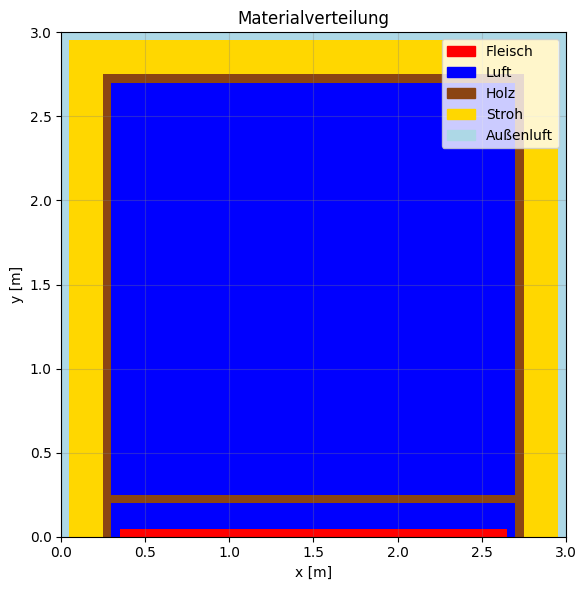

In [97]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def get_material_matrix(tile_matrix):
    n = len(tile_matrix)
    mat_array = np.zeros((n, n), dtype=int)

    for i in range(n):       # x-Achse (Spalten)
        for j in range(n):   # y-Achse (Zeilen)
            tile = tile_matrix[i][j]
            if tile.mat is Fleisch:
                mat_array[j, i] = 1
            elif tile.mat is Luft:
                mat_array[j, i] = 2
            elif tile.mat is Holz:
                mat_array[j, i] = 3
            elif tile.mat is Stroh:
                mat_array[j, i] = 4
            elif tile.mat is Aussenluft:
                mat_array[j, i] = 5
            else:
                mat_array[j, i] = 0
    return mat_array


# 2. Farben definieren
colors = ['red', 'blue', 'saddlebrown', 'gold', 'lightblue']  # für IDs 0-5
cmap = ListedColormap(colors)

# 3. Map erzeugen
material_map = get_material_matrix(tile_matrix)

plt.figure(figsize=(6, 6))
plt.imshow(material_map, cmap=cmap, origin='lower',
           extent=[0, n*delta_x, 0, n*delta_y])
plt.title("Materialverteilung")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.grid(True, color='gray', alpha=0.3)

# 4. Legende manuell erstellen
legende = [
    mpatches.Patch(color='red', label='Fleisch'),
    mpatches.Patch(color='blue', label='Luft'),
    mpatches.Patch(color='saddlebrown', label='Holz'),
    mpatches.Patch(color='gold', label='Stroh'),
    mpatches.Patch(color='lightblue', label='Außenluft'),
]

plt.legend(handles=legende, loc='upper right')
plt.tight_layout()
plt.show()

Die Grafik hierüber zeigt nun eindrücklich den Aufbau des beschriebenen Gebäudes.

Nochmal mit verfeinertem Gitter: 

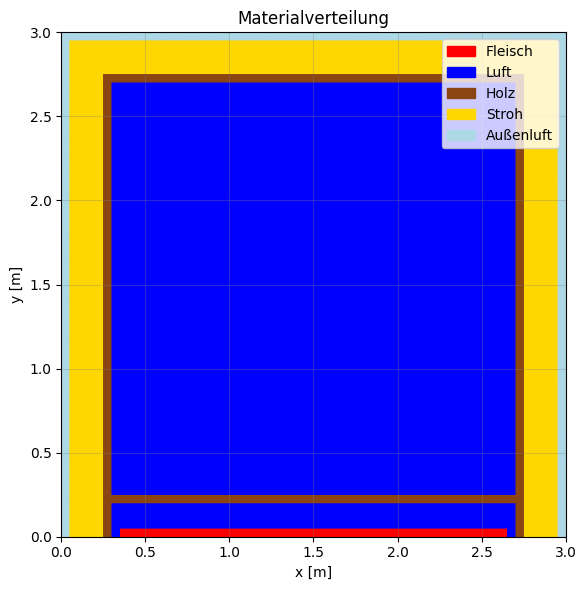

In [98]:
material_map = get_material_matrix(refined_grid(n, delta_x, delta_y, 3)[1])

plt.figure(figsize=(6, 6))
plt.imshow(material_map, cmap=cmap, origin='lower',
           extent=[0, n*delta_x, 0, n*delta_y])
plt.title("Materialverteilung")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.grid(True, color='gray', alpha=0.3)

legende = [
    mpatches.Patch(color='red', label='Fleisch'),
    mpatches.Patch(color='blue', label='Luft'),
    mpatches.Patch(color='saddlebrown', label='Holz'),
    mpatches.Patch(color='gold', label='Stroh'),
    mpatches.Patch(color='lightblue', label='Außenluft'),
]

plt.legend(handles=legende, loc='upper right')
plt.tight_layout()
plt.show()

### Einwand zu Konvektion:

Eine Konvektion wird in dieser Berechng nicht berücksichtigt. Allerdings würde dies zu stark von der Realität abweichenden Ergebnissen führen, daher wird hier die eine Anpassung der Leitfähigkeit vorgenommen. Sobalb zwei Zellen, die nur Luft enthalten, nebeneinander liegen, wird eine erhöhte Leitfähigkeit eingesetzt. Somit wird auch die erste Anforderung aus HA3 Aufg. 3 erfüllt, da die luft hier als Feststoff behandelt wird. 

In [99]:
# Hilfsfunktion: effektive Leitfähigkeit
def edge_cond(mat_p, mat_q):
    # "Konvektion light": Luft-Luft-Kontakt stark koppeln
    if mat_p == Luft and mat_q == Luft:
        return 5.0  # W/(m·K) – bewusst modellierter Ersatz für Konvektion
    # sonst wie bisher: arithmetisches Mittel
    return (mat_p.lambd + mat_q.lambd) / 2.0

## 2. Stationärer Fall:

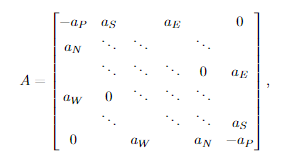

### Implementierung

#### Herleitung der Systemmatrix $A$ für den stationären Fall

Ausgangspunkt ist die stationäre Wärmeleitungs­gleichung im Finite-Volume-Ansatz (Kontrollvolumenmethode) für ein zweidimensionales, kartesisches Gitter. Für ein Kontrollvolumen $P$ mit den Nachbarzellen $W, E, N, S$ gilt im stationären Zustand:

$$
a_W \,(T_W - T_P) + a_E \,(T_E - T_P) + a_N \,(T_N - T_P) + a_S \,(T_S - T_P) = Q_P
$$

wobei:
- $T_P$ = Temperatur im Volumenmittelpunkt $P$
- $T_W, T_E, T_N, T_S$ = Temperaturen in den benachbarten Volumina
- $a_Q$ = effektive Leitfähigkeit in Richtung $Q$ (W/m$^2$K)
- $Q_P$ = Wärmequellen­term bzw. Randbeitrag (kommt später in den rechten Vektor $\vec{S}$)


#### Effektive Leitfähigkeit zwischen zwei Zellen
Die Wärmeleitfähigkeit $a_Q$ zwischen Zelle $P$ und Nachbar $Q$ wird in der Funktion `edge_cond` berechnet.  
Standardmäßig wird das arithmetische Mittel der beiden Materialleitfähigkeiten verwendet, mit einer Sonderregel:
- Wenn beide Zellen Luft enthalten, wird $a_Q = 5.0$ W/(m·K) gesetzt, um konvektive Kopplung zu modellieren.


#### Aufstellen der Gleichung in Matrixform
Die obige Bilanzgleichung kann umgestellt werden zu:

$$
a_W T_W + a_E T_E + a_N T_N + a_S T_S - (a_W + a_E + a_N + a_S) T_P = Q_P
$$

Bringt man alle Terme mit $T$ auf die linke Seite, ergibt sich:
- **Diagonale:** $A_{pp} = a_P = a_W + a_E + a_N + a_S$ (positiv)
- **Nebendiagonalen:** $A_{p,q} = -a_Q$ für jeden existierenden Nachbarn $q$



#### Randbehandlungen im Code
1. **Dirichlet-Randbedingung (feste Temperatur)**  
   Für Materialien wie `Fleisch` oder `Aussenluft` wird die Zeile in $A$ als Einheitszeile gesetzt ($A_{pp} = 1$, alle anderen Null).  
   Der zugehörige Wert geht in den rechten Vektor $\vec{S}$.

2. **Innere Nachbarn**  
   Wenn in einer Richtung ein Nachbar existiert, wird der Off-Diagonal-Eintrag auf $-a_Q$ gesetzt und $a_Q$ zur Diagonalsumme $a_P$ addiert.

3. **Rand ohne Nachbar (Robin-Bedingung)**  
   Wenn in einer Richtung kein Nachbar existiert, wird der Wärmeübergang zur Umgebung modelliert:  
   Der Wert $\lambda_P$ wird zur Diagonalsumme addiert, und der zugehörige Beitrag $\lambda_P T_\infty$ kommt in $\vec{S}$ (in dieser Matrixfunktion nicht enthalten, sondern in der Vektor-Erstellung).


#### Diagonaleintrag
Nachdem alle Nachbarn und eventuelle Randbeiträge verarbeitet wurden, wird der Diagonaleintrag der Zeile auf die Summe $a_P$ gesetzt:

$$
A_{pp} = a_W + a_E + a_N + a_S
$$

Dies stellt sicher, dass die Bilanzgleichung für das Volumen korrekt in Matrixform abgebildet ist.


#### Ergebnis
Die so konstruierte Matrix $A$ ist eine **M-Matrix**:
- Diagonalelemente positiv
- Off-Diagonalelemente nicht-positiv
- Diagonal­dominanz in jeder Zeile  

Das garantiert Stabilität und eindeutige Lösbarkeit für den stationären Wärmeleitungsfall.


In [100]:
def create_matrix_A(tiles, tile_matrix):
    n = len(tile_matrix)
    N = len(tiles)
    A = np.zeros((N, N), dtype=np.float32)
    for p, tile_p in enumerate(tiles):
        i = p // n 
        j = p % n 
        a_p = 0

        if tile_p.mat == Fleisch:
            A[p, p] = 1
            continue

        if tile_p.mat == Aussenluft:
            A[p, p] = 1
            continue

        # WEST (i, j-1)
        if j - 1 >= 0:
            tile_w = tile_matrix[i][j - 1]
            a_w = edge_cond(tile_p.mat, tile_w.mat)
            q = i * n + (j - 1)
            A[p, q] = -a_w
            a_p += a_w
        else:
            a_p += tile_p.mat.lambd

        # EAST (i, j+1)
        if j + 1 < n:
            tile_e = tile_matrix[i][j + 1]
            a_e = edge_cond(tile_p.mat, tile_e.mat)
            q = i * n + (j + 1)
            A[p, q] = -a_e
            a_p += a_e
        else:
            a_p += tile_p.mat.lambd

        # NORTH (i-1, j)
        if i - 1 >= 0:
            tile_n = tile_matrix[i - 1][j]
            a_n = edge_cond(tile_p.mat, tile_n.mat)
            q = (i - 1) * n + j
            A[p, q] = -a_n
            a_p += a_n
        else:
            a_p += tile_p.mat.lambd

        # SOUTH (i+1, j)
        if i + 1 < n:
            tile_s = tile_matrix[i + 1][j]
            a_s = edge_cond(tile_p.mat, tile_s.mat)
            q = (i + 1) * n + j
            A[p, q] = -a_s
            a_p += a_s
        else:
            a_p += tile_p.mat.lambd

        # Diagonaleintrag
        A[p, p] = a_p
    return A
        

Im weiteren Verlauf, vorallem durch die Verfeinerung, kamm es zu Problemen mit der Rechenleistung. Deshalb gibt es hier nochmal Matrix A erstellt mit Hilfe von scipy.sparse. Dabei werden die Elemente die 0 sind, nicht gespeichert und somit die Rechenleistung reduziert. 

In [101]:
import numpy as np
import scipy.sparse as sp

def create_matrix_A_sparse(tiles, tile_matrix):
    n = len(tile_matrix)
    N = len(tiles)

    rows = []
    cols = []
    data = []

    def add(r, c, v):
        rows.append(r); cols.append(c); data.append(np.float32(v))

    for p, tile_p in enumerate(tiles):
        i = p // n
        j = p % n

        # Dirichlet: Einheitszeile
        if tile_p.mat in (Fleisch, Aussenluft):
            add(p, p, 1.0)
            continue

        a_p = 0.0

        # WEST (i, j-1)
        if j - 1 >= 0:
            tile_w = tile_matrix[i][j - 1]
            a_w = edge_cond(tile_p.mat, tile_w.mat)
            add(p, i * n + (j - 1), -a_w)
            a_p += a_w
        else:
            a_p += tile_p.mat.lambd  # Rand (z.B. Robin/Neumann)

        # EAST (i, j+1)
        if j + 1 < n:
            tile_e = tile_matrix[i][j + 1]
            a_e = edge_cond(tile_p.mat, tile_e.mat)
            add(p, i * n + (j + 1), -a_e)
            a_p += a_e
        else:
            a_p += tile_p.mat.lambd

        # NORTH (i-1, j)
        if i - 1 >= 0:
            tile_n = tile_matrix[i - 1][j]
            a_n = edge_cond(tile_p.mat, tile_n.mat)
            add(p, (i - 1) * n + j, -a_n)
            a_p += a_n
        else:
            a_p += tile_p.mat.lambd

        # SOUTH (i+1, j)
        if i + 1 < n:
            tile_s = tile_matrix[i + 1][j]
            a_s = edge_cond(tile_p.mat, tile_s.mat)
            add(p, (i + 1) * n + j, -a_s)
            a_p += a_s
        else:
            a_p += tile_p.mat.lambd

        # Diagonale
        add(p, p, a_p)

    # COO → CSR (duplikate Einträge werden automatisch summiert)
    A = sp.coo_matrix((np.array(data, dtype=np.float32),
                       (np.array(rows), np.array(cols))),
                      shape=(N, N), dtype=np.float32).tocsr()
    return A


### Herleitung des rechten Vektors $\vec{S}$ für den stationären Fall

Der Vektor $\vec{S}$ enthält alle Terme der stationären Wärmebilanz, die **nicht** von den Unbekannten $T_P$ abhängen.  
Er repräsentiert in diesem Modell die Beiträge aus festen Temperaturen (Dirichlet-Bedingungen) und die Randkopplung zur Umgebungsluft (Robin-Bedingungen).
    

#### 1. Dirichlet-Randbedingungen
Befindet sich eine Zelle $P$ an einer Stelle mit fest vorgegebener Temperatur $T_\text{fix}$, so gilt:
$$
S_p = T_\text{fix}
$$
und die Zeile $p$ in der Matrix $A$ ist eine Einheitszeile ($A_{pp} = 1$, alle anderen Einträge Null).  
In deinem Code wird `tile_p.temps[0]` als fester Temperaturwert genutzt.


#### 2. Robin-Randbedingungen (konvektiver Wärmeübergang)
Befindet sich eine Zelle $P$ am Rand ohne direkten Nachbarn in einer Richtung, wird der Wärmefluss zur Umgebung gemäß:
$$
- \lambda_P \frac{\partial T}{\partial n} = h \,(T_P - T_\infty)
$$
in einer stark vereinfachten Form berücksichtigt, wobei hier $h$ in $\lambda_P$ enthalten ist.

Numerisch wird der Beitrag zum rechten Vektor als:
$$
S_p \; \mathrel{+}= \; \lambda_P \, T_\infty
$$
addiert, wenn ein Nachbar in der betrachteten Richtung fehlt.


#### 3. Implementierungsdetails
Im Code wird dies folgendermaßen umgesetzt:
- **West-Rand**: Falls $j - 1 < 0$ → $S_p \mathrel{+}= \lambda_P T_u$
- **Ost-Rand**: Falls $j + 1 \ge n$ → $S_p \mathrel{+}= \lambda_P T_u$
- **Nord-Rand**: Falls $i - 1 < 0$ → $S_p \mathrel{+}= \lambda_P T_u$
- **Süd-Rand**: Falls $i + 1 \ge n$ → $S_p \mathrel{+}= \lambda_P T_u$

Hierbei bezeichnet $T_u$ die Umgebungstemperatur $T_\infty$.


#### 4. Ergebnis
Der Vektor $\vec{S}$ enthält somit:
- Feste Temperaturwerte für Dirichlet-Zellen
- Summierte Robin-Beiträge für äußere Ränder ohne direkten Nachbarn
- Keine expliziten Quellen innerhalb des Gebiets (könnten bei Bedarf analog ergänzt werden)

Dieser Vektor geht direkt in das stationäre Gleichungssystem ein:
$$
A \, \vec{T} = \vec{S}
$$
wobei $A$ die aus der Diskretisierung erhaltene Systemmatrix ist.


In [102]:
def create_vector_S(tiles, tile_matrix, T_u):
    n = len(tile_matrix)
    N = len(tiles)
    S = np.zeros(N, dtype=np.float32)

    for p, tile_p in enumerate(tiles):
        i = p // n 
        j = p % n 

        # Dirichlet
        if tile_p.mat in (Fleisch, Aussenluft):
            S[p] = tile_p.temps[0]
            continue

        # Robin-Beiträge: fehlender Nachbar -> + lambda_P * T_u
        lam = tile_p.mat.lambd
        if j - 1 < 0: S[p] += lam * T_u  # West
        if j + 1 >= n: S[p] += lam * T_u # East
        if i - 1 < 0: S[p] += lam * T_u  # North
        if i + 1 >= n: S[p] += lam * T_u # South

    return S

Nun wird die Matrize und der Vektor erstellt un gelöst.

In [103]:
A = create_matrix_A(tiles, tile_matrix)
S = create_vector_S(tiles, tile_matrix, T_u)
T = np.linalg.solve(A, S)

Ein kleiner Test der Formgebung: 

In [104]:
T

array([273.15, 273.15, 273.15, ..., 273.15, 273.15, 273.15],
      shape=(3600,), dtype=float32)

### Ergebnisplot

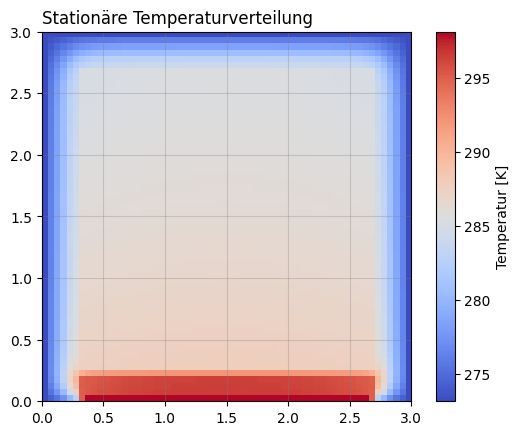

In [105]:

T_grid = T.reshape(n, n).T  # 2D-Form herstellen

plt.imshow(T_grid, cmap='coolwarm', origin='lower',
           extent=[0, delta_x * n, 0, delta_y * n],
           vmin=273.15, vmax=298.15)
plt.title("Stationäre Temperaturverteilung", loc='left')
plt.colorbar(label='Temperatur [K]')
plt.grid(True, color='gray', alpha=0.3)

plt.savefig("stationaer.png", dpi=300, bbox_inches='tight')
plt.show()


### Diskussion:

Abbildung~\ref{fig:stationaer} zeigt die berechnete stationäre Temperaturverteilung im untersuchten Gebäudemodell. 
Der Temperaturbereich reicht von etwa 273,15 K (0°C) im Bereich der Außenluft 
bis zu knapp 296 K (ca. 23°C) im Bereich oberhalb der Tierkörper.

Wie erwartet, ist im unteren Bereich des Modells, an der Position der Tiere, eine deutlich erhöhte Temperatur zu erkennen. 
Diese Wärme breitet sich über die Holzbalken und den Zwischenboden in den darüberliegenden Wohnbereich aus. 
Durch Wärmeleitung und die gewählte Randmodellierung fällt die Temperatur jedoch zum Dach hin deutlich ab.

Der Temperaturverlauf ist symmetrisch, was der gewählten Geometrie und der gleichmäßigen Wärmequelle im unteren Bereich entspricht. 
Die stärksten Gradienten treten an den Außenwänden sowie an der Grenze zwischen beheiztem Stallbereich und kühlerer Luft auf. 
Im zentralen Innenbereich des Wohnraums stellt sich ein nahezu homogenes Temperaturniveau ein, das allerdings merklich 
unter der Temperatur im Stallbereich liegt.

Diese Ergebnisse stimmen qualitativ mit der physikalischen Erwartung überein:

- Wärmequelle im Stall $\rightarrow$ Temperaturmaximum im unteren Innenbereich
- Wärmeverluste an den Außenflächen $\rightarrow$ Abnahme der Temperatur in Wandnähe und nach oben
- Symmetrie aufgrund gleichmäßiger Geometrie und Randbedingungen



## 3. Gitteranalyse:

### Auswahl der Vergleichspunkte, Begründung

Für die Gitteranalyse werden nun die folgenden Zellen gewählt. 

Zelle 1770: Diese liegt mittig im Gitter und stellt auch die Mitte des Wohnraums dar. Somit ist eine gute Referenz für die Raumtemperatur. 

In [106]:
print("x:",tiles[1770].x, "   y:", tiles[1770].y)

x: 1.475    y: 1.525


Zelle 1743: Diese liegt in der Strohdämmung, wo der Gradient besonders hoch ist. 

In [107]:
print("x:",tiles[1743].x, "   y:", tiles[1743].y)

x: 1.475    y: 0.17500000000000002


Zelle 1745: Diese liegt in der Holzwand und ist von zwei verscheiden Materialien umgeben.

In [108]:
print("x:",tiles[1745].x, "   y:", tiles[1745].y)

x: 1.475    y: 0.275


Zelle 367: Diese liegt in der unteren Ecke des Raumes. Diese Zelle ist interessant, da sie zwar vollständig von Luft umgeben ist, aber einen geringen Abstand zu Wärmequelle als auch zur Wärmesenke hat. 

In [109]:
print("x:",tiles[367].x, "   y:", tiles[367].y)

x: 0.32500000000000007    y: 0.37500000000000006


Zelle 270: Diese liegt in der Mitte des Holzbodens und stelle die Stelle des größten Wärmeübergangs zwischen unterem und oberen Raum dar.

In [110]:
print("x:",tiles[270].x, "   y:", tiles[270].y)

x: 0.225    y: 1.525


Zelle 90: Diese liegt direkt über den Tieren.

In [111]:
print("x:",tiles[90].x, "   y:", tiles[90].y)

x: 0.07500000000000001    y: 1.525


Hier erstelle ich eine Liste mit den betrachteten Punkten um einfach auf diese Zugreifen zu können. 

In [112]:
target_list = [1770, 1743, 1745, 367,  270, 90]

Durch die Funktion edit_material_map() kann die vorher verwendete Funktion get_material_matrix weiter verwendet werden um die Punkte grafisch darzustellen. 

In [113]:
def edit_material_map(material_map, target_list, refine_exponent):
    refine_factor = 2 ** refine_exponent
    for target in target_list:
        i = target // (n*refine_factor)
        j = target % (n*refine_factor)
        material_map[i,j] = 6
    return material_map

Da dieser Code wieder keine Mathematische Funktion hat, werde ich ihn nicht erklären. 

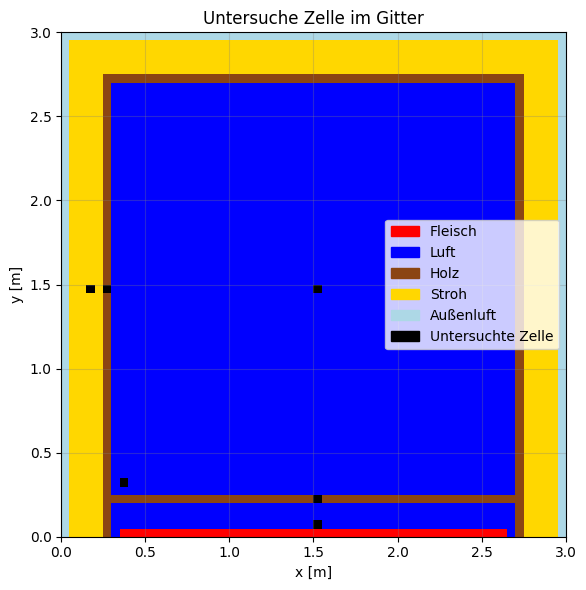

In [114]:
material_map = get_material_matrix(tile_matrix)
#refined_grid(n, delta_x, delta_y, 3)[1]
material_map = edit_material_map(material_map, target_list, 0)

colors = ['red', 'blue', 'saddlebrown', 'gold', 'lightblue', 'black']  # für IDs 0-6
cmap = ListedColormap(colors)
plt.figure(figsize=(6, 6))
plt.imshow(material_map, cmap=cmap, origin='lower',
           extent=[0, n*delta_x, 0, n*delta_y])
plt.title("Untersuche Zelle im Gitter")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.grid(True, color='gray', alpha=0.3)

legende = [
    mpatches.Patch(color='red', label='Fleisch'),
    mpatches.Patch(color='blue', label='Luft'),
    mpatches.Patch(color='saddlebrown', label='Holz'),
    mpatches.Patch(color='gold', label='Stroh'),
    mpatches.Patch(color='lightblue', label='Außenluft'),
    mpatches.Patch(color='black', label='Untersuchte Zelle')
]

plt.legend(handles=legende, loc='right')
plt.tight_layout()
plt.show()

### Rechnung ohne Verfeinerung:

Nun wird das System nochmal mit einer Sparse matrix gelöst.

In [115]:
A = create_matrix_A_sparse(tiles, tile_matrix)
S = create_vector_S(tiles, tile_matrix, T_u)

from scipy.sparse.linalg import spsolve
T = spsolve(A, S)

### Rechnung mit Verfeinerung 1:

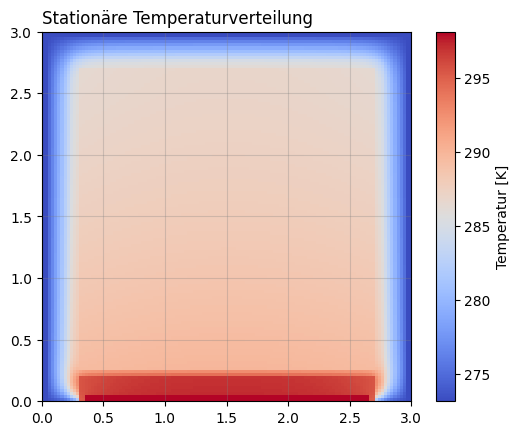

In [116]:

r1_tiles, r1_tile_matrix = refined_grid(n, delta_x, delta_y,1)
A_r1 = create_matrix_A_sparse(r1_tiles, r1_tile_matrix)
S_r1 = create_vector_S(r1_tiles, r1_tile_matrix, T_u)
T_r1 = spsolve(A_r1, S_r1)

T_grid_r1 = T_r1.reshape(n*2, n*2).T  # 2D-Form herstellen

plt.imshow(T_grid_r1, cmap='coolwarm', origin='lower',
           extent=[0, delta_x * n, 0, delta_y * n],
           vmin=273.15, vmax=298.15)
plt.title("Stationäre Temperaturverteilung", loc='left')
plt.colorbar(label='Temperatur [K]')
plt.grid(True, color='gray', alpha=0.3)

plt.savefig("stationaer_1.png", dpi=300, bbox_inches='tight')
plt.show()

In [117]:
n

60

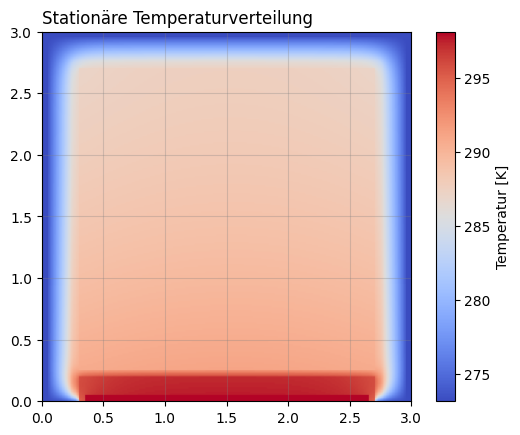

In [118]:
r2_tiles, r2_tile_matrix = refined_grid(n, delta_x, delta_y,2)
A_r2 = create_matrix_A_sparse(r2_tiles, r2_tile_matrix)
S_r2 = create_vector_S(r2_tiles, r2_tile_matrix, T_u)
T_r2 = spsolve(A_r2, S_r2)

T_grid_r2 = T_r2.reshape(n*4, n*4).T  # 2D-Form herstellen

plt.imshow(T_grid_r2, cmap='coolwarm', origin='lower',
           extent=[0, delta_x * n, 0, delta_y * n],
           vmin=273.15, vmax=298.15)
plt.title("Stationäre Temperaturverteilung", loc='left')
plt.colorbar(label='Temperatur [K]')
plt.grid(True, color='gray', alpha=0.3)

plt.savefig("stationaer_2.png", dpi=300, bbox_inches='tight')
plt.show()

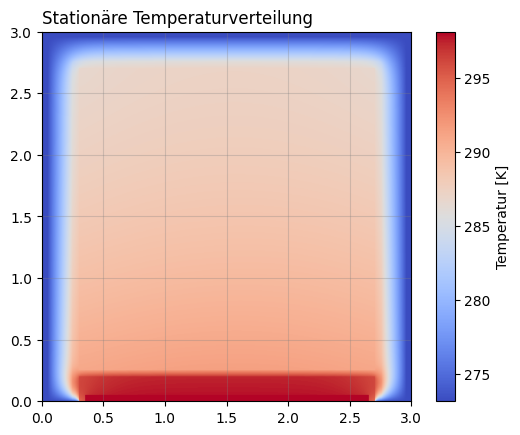

In [119]:
r3_tiles, r3_tile_matrix = refined_grid(n, delta_x, delta_y,3)
A_r3 = create_matrix_A_sparse(r3_tiles, r3_tile_matrix)
S_r3 = create_vector_S(r3_tiles, r3_tile_matrix, T_u)
T_r3 = spsolve(A_r3, S_r3)

T_grid_r3 = T_r3.reshape(n*8, n*8).T  # 2D-Form herstellen

plt.imshow(T_grid_r3, cmap='coolwarm', origin='lower',
           extent=[0, delta_x * n, 0, delta_y * n],
           vmin=273.15, vmax=298.15)
plt.title("Stationäre Temperaturverteilung", loc='left')
plt.colorbar(label='Temperatur [K]')
plt.grid(True, color='gray', alpha=0.3)

plt.savefig("stationaer_3.png", dpi=300, bbox_inches='tight')
plt.show()

Nun wird untersucht, ob nach der Verfeinerung auch weiterhin die richtigen Zellen genommen werden. 

In [120]:
def refined_target_list(n, target_list, refine_exponent):
    re = refine_exponent
    r_target_list = []
    for target in target_list:
        r_target_list.append(target * 2**re )# + 2**(re-1) - 1)
        #r_target_list.append(target * 2**re + 2**(re-1))
        #r_target_list.append(target * 2**re + 2**(re-1) - 1 + 2**re*n)
        #r_target_list.append(target * 2**re + 2**(re-1) + 2**re*n)
    return r_target_list
    

In [121]:
def refined_target_list_2x2(n, target_list, refine_exponent):
    scale = 2 ** refine_exponent
    n_fine = n * scale
    off = scale // 2 - 1
    out = []
    for p in target_list:
        row = p // n
        col = p - row * n
        i0 = row * scale + off
        j0 = col * scale + off
        base = i0 * n_fine + j0
        out += [base, base + 1, base + n_fine, base + n_fine + 1]
    return out

In [122]:
def refined_target_list_center2x2(n, target_list, refine_exponent):
    """
    n: Breite/Höhe des Grobrasters (n x n)
    target_list: flache Indizes im Grobraster (row-major)
    refine_exponent: Verfeinerung um Faktor s = 2**refine_exponent
    Rückgabe: flache Indizes im feinen Raster (n*s x n*s) für den 2x2-Mittelblock.
    """
    s = 1 << refine_exponent            # s = 2**refine_exponent
    if s < 2:
        return target_list[:]           # keine Verfeinerung

    n_fine = n * s
    out = []
    for p in target_list:
        i_c, j_c = divmod(p, n)         # Grob-Indizes
        i0, j0 = i_c * s, j_c * s       # Start des feinen Elternblocks
        ci, cj = i0 + (s//2 - 1), j0 + (s//2 - 1)  # zentrierter 2x2-Start

        # vier feine Zellen (row-major)
        base = ci * n_fine + cj
        out.extend([base, base + 1, base + n_fine, base + n_fine + 1])
    return out

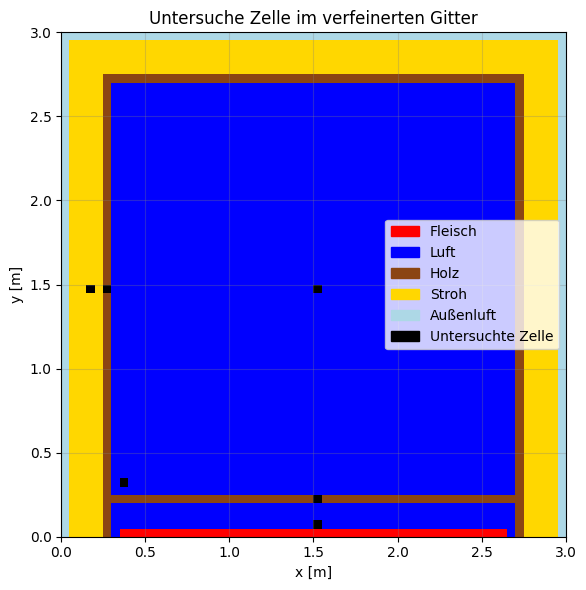

In [123]:
material_map = get_material_matrix(refined_grid(n, delta_x, delta_y, 1)[1])
r_target_list = refined_target_list_2x2(n, target_list, 1)
material_map = edit_material_map(material_map, r_target_list, 1)

colors = ['red', 'blue', 'saddlebrown', 'gold', 'lightblue', 'black']  # für IDs 0-6
cmap = ListedColormap(colors)
plt.figure(figsize=(6, 6))
plt.imshow(material_map, cmap=cmap, origin='lower',
           extent=[0, n*delta_x, 0, n*delta_y])
plt.title("Untersuche Zelle im verfeinerten Gitter")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.grid(True, color='gray', alpha=0.3)

legende = [
    mpatches.Patch(color='red', label='Fleisch'),
    mpatches.Patch(color='blue', label='Luft'),
    mpatches.Patch(color='saddlebrown', label='Holz'),
    mpatches.Patch(color='gold', label='Stroh'),
    mpatches.Patch(color='lightblue', label='Außenluft'),
    mpatches.Patch(color='black', label='Untersuchte Zelle')
]

plt.legend(handles=legende, loc='right')
plt.tight_layout()
plt.show()

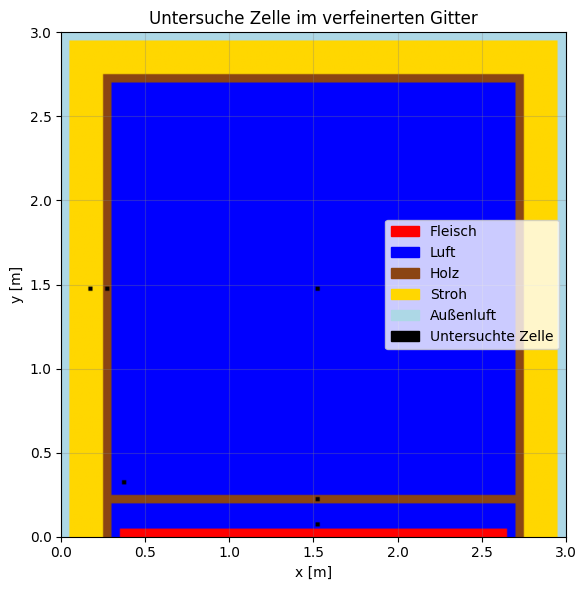

In [124]:
material_map = get_material_matrix(refined_grid(n, delta_x, delta_y, 2)[1])
r_target_list = refined_target_list_2x2(n, target_list, 2)
material_map = edit_material_map(material_map, r_target_list, 2)

colors = ['red', 'blue', 'saddlebrown', 'gold', 'lightblue', 'black']  # für IDs 0-6
cmap = ListedColormap(colors)
plt.figure(figsize=(6, 6))
plt.imshow(material_map, cmap=cmap, origin='lower',
           extent=[0, n*delta_x, 0, n*delta_y])
plt.title("Untersuche Zelle im verfeinerten Gitter")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.grid(True, color='gray', alpha=0.3)

legende = [
    mpatches.Patch(color='red', label='Fleisch'),
    mpatches.Patch(color='blue', label='Luft'),
    mpatches.Patch(color='saddlebrown', label='Holz'),
    mpatches.Patch(color='gold', label='Stroh'),
    mpatches.Patch(color='lightblue', label='Außenluft'),
    mpatches.Patch(color='black', label='Untersuchte Zelle')
]

plt.legend(handles=legende, loc='right')
plt.tight_layout()
plt.show()

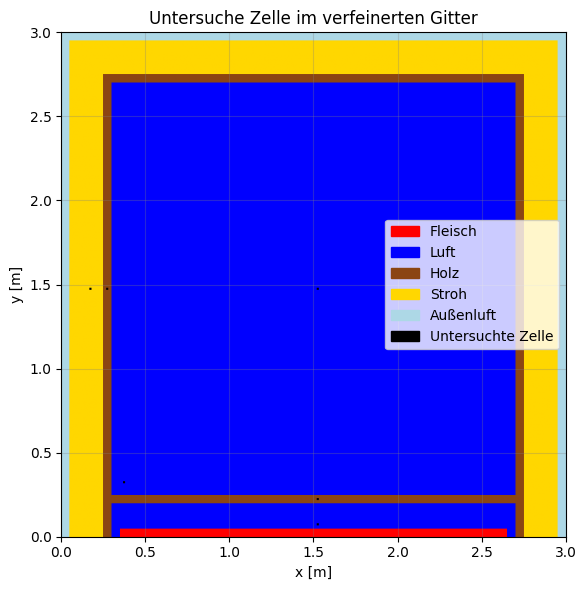

In [125]:
material_map = get_material_matrix(refined_grid(n, delta_x, delta_y, 3)[1])
r_target_list = refined_target_list_2x2(n, target_list, 3)
material_map = edit_material_map(material_map, r_target_list, 3)

colors = ['red', 'blue', 'saddlebrown', 'gold', 'lightblue', 'black']  # für IDs 0-6
cmap = ListedColormap(colors)
plt.figure(figsize=(6, 6))
plt.imshow(material_map, cmap=cmap, origin='lower',
           extent=[0, n*delta_x, 0, n*delta_y])
plt.title("Untersuche Zelle im verfeinerten Gitter")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.grid(True, color='gray', alpha=0.3)

legende = [
    mpatches.Patch(color='red', label='Fleisch'),
    mpatches.Patch(color='blue', label='Luft'),
    mpatches.Patch(color='saddlebrown', label='Holz'),
    mpatches.Patch(color='gold', label='Stroh'),
    mpatches.Patch(color='lightblue', label='Außenluft'),
    mpatches.Patch(color='black', label='Untersuchte Zelle')
]

plt.legend(handles=legende, loc='right')
plt.tight_layout()
plt.show()

### Berechnung des gemittelten relativen Fehlers

In [126]:
T_base = [] # 
r3_target_list = refined_target_list_2x2(n, target_list, 3)
i = 0
value = 0
for t in r3_target_list:
    value += T_r3[t]/4
    i += 1
    if i == 4:
        i = 0
        T_base.append(value)
        value = 0
T_base

[np.float32(288.58835),
 np.float32(297.48517),
 np.float32(291.40167),
 np.float32(290.6242),
 np.float32(285.24304),
 np.float32(275.1763)]

In [127]:
T_2 = [] # 
r2_target_list = refined_target_list_2x2(n, target_list, 2)
i = 0
value = 0
for t in r2_target_list:
    value += T_r2[t]/4
    i += 1
    if i == 4:
        i = 0
        T_2.append(value)
        value = 0
T_2

[np.float32(288.80078),
 np.float32(297.32285),
 np.float32(291.11447),
 np.float32(290.4331),
 np.float32(285.43274),
 np.float32(275.49634)]

In [128]:
T_1 = [] # 
r1_target_list = refined_target_list_2x2(n, target_list, 1)
i = 0
value = 0
for t in r1_target_list:
    value += T_r1[t]/4
    i += 1
    if i == 4:
        i = 0
        T_1.append(value)
        value = 0
T_1

[np.float32(287.91656),
 np.float32(296.9759),
 np.float32(289.85446),
 np.float32(289.2732),
 np.float32(284.74362),
 np.float32(275.86398)]

In [129]:
T_0 = [] 
target_list
i = 0
value = 0
for t in target_list:
    value += T[t]
    T_0.append(value)
    value = 0
T_0

[np.float32(286.2214),
 np.float32(296.41898),
 np.float32(287.75363),
 np.float32(287.2987),
 np.float32(283.4094),
 np.float32(276.3074)]

In [130]:
d_list = []

In [131]:
d_0 =  np.array(T_0) -  np.array(T_base)
d_list.append(d_0)
d_0

array([-2.3669434, -1.0661926, -3.6480408, -3.3255005, -1.8336487,
        1.1311035], dtype=float32)

In [132]:
d_1 =  np.array(T_1) -  np.array(T_base)
d_list.append(d_1)
d_1

array([-0.67178345, -0.50927734, -1.5472107 , -1.3510132 , -0.49942017,
        0.6876831 ], dtype=float32)

In [133]:
d_2 =  np.array(T_2) -  np.array(T_base)
d_list.append(d_2)
d_2

array([ 0.21243286, -0.162323  , -0.28720093, -0.19110107,  0.18969727,
        0.32003784], dtype=float32)

In [134]:
d_3 = [0,0,0,0,0,0]
d_list.append(d_3)

### Rechenzeiten:

In [135]:
import time

In [136]:
times_to_calc = []

In [137]:
def run_timed(func, /, *args, **kwargs):
    t0 = time.perf_counter()
    try:
        result = func(*args, **kwargs)
        return result, time.perf_counter() - t0
    except Exception:
        elapsed = time.perf_counter() - t0
        # elapsed bei Bedarf loggen oder an Exception anhängen
        raise

In [138]:
def average_over_five(func, /, *args, **kwargs):
    t = 0.0
    for _ in range(5):
        _, dt = run_timed(func, *args, **kwargs) 
        t += dt
    return t / 5

In [139]:
times_to_calc.append(average_over_five(spsolve, A, S))

In [140]:
times_to_calc.append(average_over_five(spsolve, A_r1, S_r1))

In [141]:
times_to_calc.append(average_over_five(spsolve, A_r2, S_r2))

In [142]:
times_to_calc.append(average_over_five(spsolve, A_r3, S_r3))

In [143]:
times_to_calc

[0.006063860001449939,
 0.029745900000852997,
 0.159245420001389,
 1.478907659999095]

In [ ]:
def plot_refinement_error_times(d_list, times_to_calc, n_list=None, use_abs=True,
                                savepath=None, drop_last_errors=True):
    S = len(d_list)
    if len(times_to_calc) != S:
        raise ValueError("times_to_calc muss gleich lang wie d_list sein.")

    E = np.stack([np.asarray(d, dtype=float) for d in d_list], axis=0)
    if use_abs:
        E = np.abs(E)
    avg = np.nanmean(E, axis=1)

    # x-Achse
    s_full = np.log2(np.asarray(n_list, dtype=float)) if n_list is not None else np.arange(S, dtype=float)

    # Fehlerkurven ohne letzten Punkt
    if drop_last_errors and S > 1:
        s_err = s_full[:-1]
        E_err = E[:-1, :]
        avg_err = avg[:-1]
    else:
        s_err = s_full
        E_err = E
        avg_err = avg

    fig, ax1 = plt.subplots(figsize=(7.5, 4.2))
    M = E_err.shape[1]

    # Zellen
    for j in range(M):
        ax1.loglog(s_err, E_err[:, j], marker='o', linewidth=1, alpha=0.65, label=f"Zelle {j+1}")

    # Durchschnitt
    ax1.loglog(s_err, avg_err, marker='s', linewidth=2, label="Durchschnitt")

    ax1.set_xlabel(r"Verfeinerung $s$" + ("" if n_list is None else r" = $\log_2(n)$"))
    ax1.set_ylabel("Abweichung (|ΔT|)" if use_abs else "Abweichung (ΔT)")
    ax1.grid(True, which='both')

    # Rechenzeiten (vollständig)
    ax2 = ax1.twinx()
    t_e = np.asarray(times_to_calc, dtype=float)
    ax2.loglog(s_full, t_e, marker='^', linestyle='-', label="Rechenzeit")
    ax2.set_ylabel("Rechenzeit [s]")

    # Legende rechts außen
    lines = ax1.get_lines() + ax2.get_lines()
    labels = [ln.get_label() for ln in lines]
    ax1.legend(lines, labels, loc='center left', bbox_to_anchor=(1.1, 0.5), borderaxespad=0.0)

    # Platz für Legende schaffen
    fig.subplots_adjust(right=0.72)

    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()
    #return fig, (ax1, ax2)

### Log-Log-Darstellung, Wahl der optimalen Gitterweite für instationären Fall

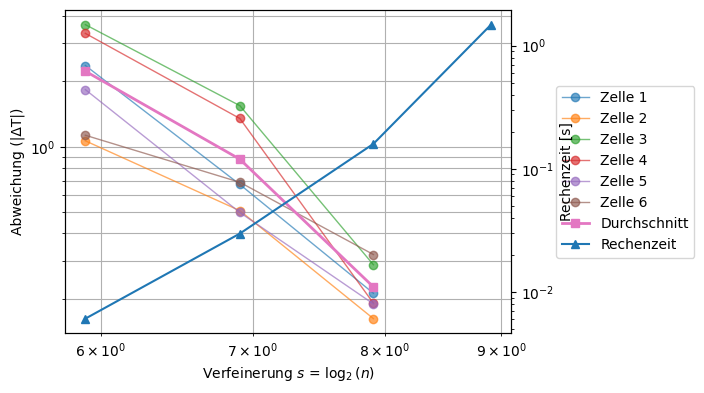

In [145]:
plot_refinement_error_times(d_list, times_to_calc, n_list=[n, 2*n, 4*n, 8*n])

# HA3

## Theorie-Aufgabe:

Da die Theorieaufgabe wahrscheinlich nicht in Programmform dargelegt werden soll, ist hier der noch handschriftliche Rechenweg. 

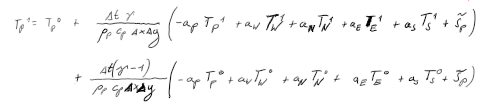

Ja, es ist aufgefallen, dass die Nummerierung der Zellen in dieser Rechnung nicht korrekt ist. Im Code wird dies an verschiedenen Stellen behoben.

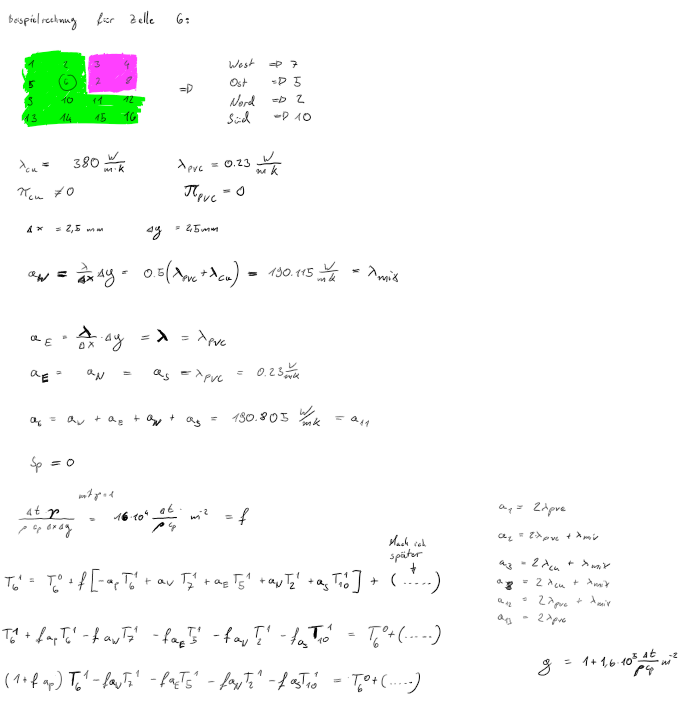

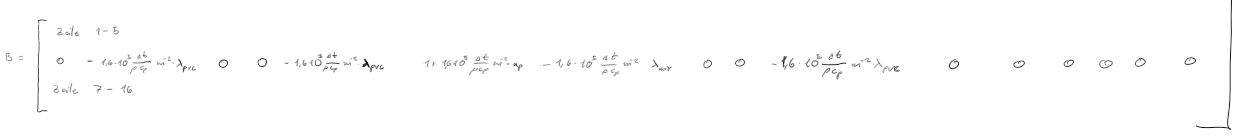

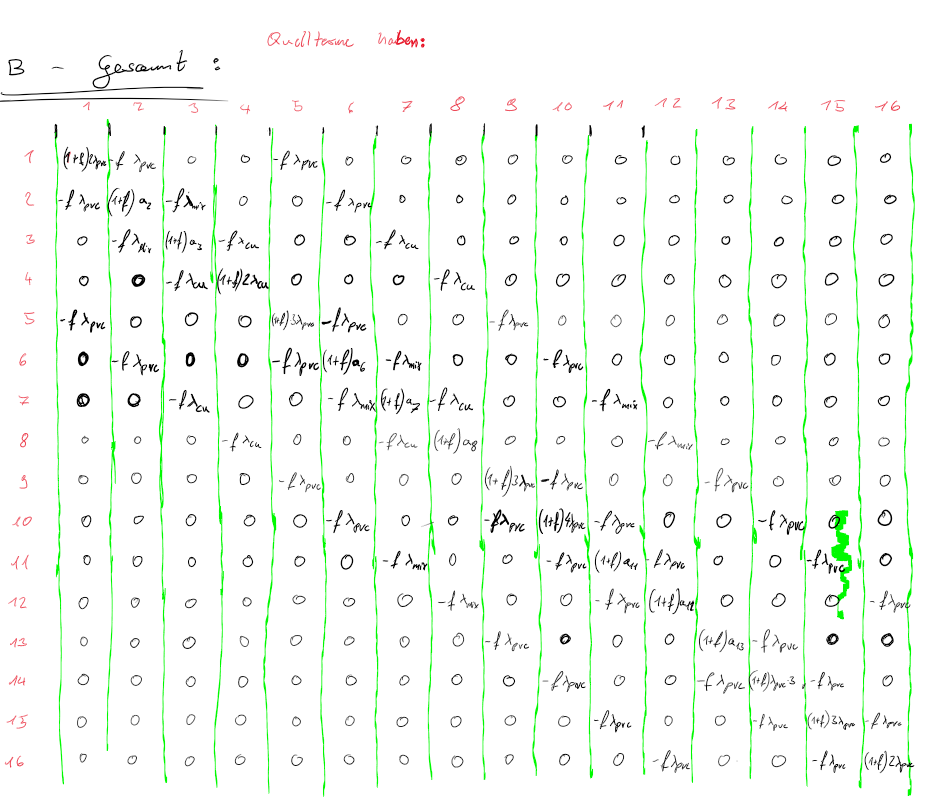

## Der Instationäre Fall:

### Aufbau und Bedeutung der Iterationsmatrix $B$:

Die Funktion `create_matrix_B` konstruiert für das instationäre $\theta$-Verfahren (mit $\gamma$ und 
$ f = \frac{\Delta t\,\gamma}{\rho_P c_P \,\Delta x\,\Delta y} $) die **Iterationsmatrix $B$** des linearen Gleichungssystems

$$
B\,\mathbf{T}^{\,1}=\mathbf{F},
$$

das pro Zeitschritt gelöst wird. Jeder Gitterzelle (Kontrollvolumen) wird dabei ein Index $p$ zugeordnet; 
die Temperatur am neuen Zeitschrittniveau $t^{n+1}$ heißt $T_p^{\,1}$.

**Indexierung und Gitterlogik.**  
Das Rechengebiet ist als äquidistentes $n\times n$-Gitter organisiert. Der lineare Zellindex 
$p\in\{0,\dots,N-1\}$ (mit $N=n^2$) wird in 2D-Koordinaten abgebildet:

$$
i=\left\lfloor \frac{p}{n}\right\rfloor \quad\text{(Zeile, Nord–Süd)},\qquad
j=p\bmod n \quad\text{(Spalte, West–Ost)}.
$$

So lassen sich die **Nachbarn** einer Zelle $(i,j)$ systematisch adressieren: West $(i,j-1)$, Ost $(i,j+1)$, Nord $(i-1,j)$, Süd $(i+1,j)$, jeweils nur, sofern sie im Gitter liegen.

**Dirichlet-Zellen (feste Temperatur).**  
Zellen, deren Material als **Fleisch** oder **Außenluft** gekennzeichnet ist, werden als **Dirichlet-Rand/Innenbedingungen** behandelt. 
Für diese Zellen wird die Temperatur fest vorgegeben; numerisch entspricht das dem **Setzen eines Einheitsgleichers**:

$$
B_{pp}=1,\quad B_{pq}=0\ \ (q\neq p).
$$

Damit entkoppeln sich diese Zellen vom restlichen System auf der linken Seite; ihr Wert geht später ausschließlich in $\mathbf{F}$ (rechte Seite) ein.

**Kopplung zu den Nachbarn.**  
Für **freie (nicht-Dirichlet-)Zellen** werden die diffusen Wärmeflüsse zu den vier Nachbarn diskretisiert. 
Zu jedem vorhandenen Nachbarn $Q\in\{W,E,N,S\}$ wird ein Leitfähigkeitskoeffizient

$$
a_Q=\frac{\lambda_P+\lambda_Q}{2}
$$

eingesetzt (arithmetisches Mittel der Materialleitfähigkeiten der beiden angrenzenden Zellen). 
Der Beitrag dieser Kopplung erscheint als **negative** Nebendiagonale in $B$:

$$
B_{p,q}=-\,f\,a_Q,
$$

wobei $q$ der lineare Index des jeweiligen Nachbarn ist.

**Diagonaleintrag (Zellbilanz).**  
Die Summe aller Kantenleitfähigkeiten der Zelle

$$
a_P=\sum_{Q\in\{W,E,N,S\}} a_Q
$$

bestimmt den Diagonaleintrag

$$
B_{p,p}=1+f\,a_P.
$$

Die „$1$“ stammt aus dem Zeitableitungs-Term (Speicherung), der Anteil $f\,a_P$ aus den implizit behandelten Diffusionstermen des $\theta$-Verfahrens mit Gewicht $\gamma$.

**Randsensitivität.**  
An äußeren Rändern fehlen Nachbarn; in diesen Richtungen entfällt der entsprechende Nebendiagonaleintrag automatisch, und $a_P$ summiert nur die existierenden Kanten. 
Dirichlet-Zellen werden bereits oben gesondert behandelt.

**Rolle des Faktors $f$.**  
Der dimensionslose Faktor

$$
f=\frac{\Delta t\,\gamma}{\rho_P c_P\,\Delta x\,\Delta y}
$$

skaliert die impliziten Diffusionsanteile. 
Größere $\Delta t$ oder kleinere $\rho c_P$ verstärken die Kopplung pro Zeitschritt; 
$\gamma=0{,}5$ (Crank–Nicolson) balanciert Stabilität und Zeitgenauigkeit zweiter Ordnung.

**Sparsame Struktur.**  
Die Matrix $B$ ist **dünn besetzt** (maximal fünf Nichtnullen pro Zeile: Zentrum plus bis zu vier Nachbarn). 
Für große Gitter ist eine Sparse-Repräsentation wesentlich effizienter als ein dichtes `np.zeros`.


In [146]:
import numpy as np

def create_matrix_B(tiles, tile_matrix):
    n = len(tile_matrix)
    N = len(tiles)
    B = np.zeros((N, N), dtype=np.float32)

    for p, tile_p in enumerate(tiles):
        i = p // n  # Zeile (x-Richtung)
        j = p % n   # Spalte (y-Richtung)


        if tile_p.mat == Fleisch:
            # Dirichlet-Bedingung: Fixe Temperatur
            B[p, p] = 1
            continue

        if tile_p.mat == Aussenluft:
            # Dirichlet-Bedingung: Fixe Temperatur
            B[p, p] = 1
            continue

        a_p = 0  # Summe aller a_Q

        # WEST (i, j-1)
        if j - 1 >= 0:
            tile_w = tile_matrix[i][j - 1]
            a_w = edge_cond(tile_p.mat, tile_w.mat)
            q = i * n + (j - 1)
            B[p, q] = -tile_p.f * a_w
            a_p += a_w

        # EAST (i, j+1)
        if j + 1 < n:
            tile_e = tile_matrix[i][j + 1]
            a_e = edge_cond(tile_p.mat, tile_e.mat)
            q = i * n + (j + 1)
            B[p, q] = -tile_p.f * a_e
            a_p += a_e

        # NORTH (i-1, j)
        if i - 1 >= 0:
            tile_n = tile_matrix[i - 1][j]
            a_n = edge_cond(tile_p.mat, tile_n.mat)
            q = (i - 1) * n + j
            B[p, q] = -tile_p.f * a_n
            a_p += a_n

        # SOUTH (i+1, j)
        if i + 1 < n:
            tile_s = tile_matrix[i + 1][j]
            a_s = edge_cond(tile_p.mat, tile_s.mat)
            q = (i + 1) * n + j
            B[p, q] = -tile_p.f * a_s
            a_p += a_s

        # Diagonaleintrag (1 + f * a_P)
        B[p, p] = 1 + tile_p.f * a_p

    return B

### Aufbau und Bedeutung des Vektors $\mathbf{F}$

Die Funktion `create_vector_F` berechnet die rechte Seite $\mathbf{F}$ des instationären $\theta$-Verfahrens

$$
B\,\mathbf{T}^{\,1} = \mathbf{F},
$$

wobei $\mathbf{F}$ alle Terme enthält, die nicht vom neuen Zeitschrittniveau $t^{n+1}$ abhängen.  
Dazu zählen die expliziten Anteile der Diffusion, Quellen- bzw. Randterme sowie die Werte aus dem vorherigen Zeitschritt $t^n$.

**Indexierung und Ausgangswerte.**  
Analog zur Matrixkonstruktion wird das $n\times n$-Gitter in einen Vektor der Länge $N=n^2$ überführt:

$$
i = \left\lfloor \frac{p}{n} \right\rfloor, \quad j = p \bmod n.
$$

Für jede Zelle $p$ wird die Temperatur des letzten Zeitschritts $T_p^0 = \texttt{tile\_p.temps[-1]}$ gelesen.  
Der Faktor

$$
g = \frac{\Delta t\,(1-\gamma)}{\rho_P c_P\,\Delta x\,\Delta y}
$$

skaliert die expliziten Beiträge.

**Dirichlet-Zellen (feste Temperatur).**  
Befindet sich in der Zelle ein Material mit fest vorgegebener Temperatur (hier: **Fleisch** oder **Außenluft**),  
so gilt direkt

$$
F_p = T_p^0,
$$

und die Zelle wird nicht mit den Nachbarn gekoppelt.

**Berechnung für freie Zellen.**  
Für alle übrigen Zellen werden die Leitfähigkeiten zu den Nachbarn addiert:

- **Innere Nachbarn**: Leitfähigkeit $a_Q = \frac{\lambda_P+\lambda_Q}{2}$ (arithmetisches Mittel)  
  geht in die Summe $a_P$ und in den gewichteten Nachbarsummenbeitrag $a_Q T_Q^0$ ein.
- **Äußere Ränder**: Wenn kein Nachbar vorhanden ist, wird eine **Robin-Randbedingung** zur Umgebung mit Temperatur $T_u$ angenommen.  
  Hier gilt $a_Q = \lambda_P$ und der Term $a_Q T_u$ geht in die Quellenbilanz ein.

**Zusammenbau von $F_p$.**  
Die rechte Seite für eine freie Zelle lautet

$$
F_p = T_p^0 + g\left(-a_P\,T_p^0 + \sum_{Q} a_Q T_Q^0 + \text{source}\right),
$$

wobei
- $a_P = \sum_{Q \in \{W,E,N,S\}} a_Q$ die Summe aller Kantenleitfähigkeiten ist,
- $\sum_{Q} a_Q T_Q^0$ die gewichtete Summe der Nachbartemperaturen beschreibt,
- $\text{source}$ die Beiträge der Randtemperaturen $T_u$ aus Robin-Bedingungen enthält.

**Physikalische Bedeutung.**  
Die Terme in $\mathbf{F}$ repräsentieren die explizit behandelten Anteile der Diffusion und alle bekannten Werte aus $t^n$.  
Dirichlet-Zellen übernehmen ihren Temperaturwert unverändert,  
Randzellen mit Robin-Bedingungen koppeln sich zusätzlich an eine feste Umgebungstemperatur.

Damit enthält $\mathbf{F}$ alle Informationen, um zusammen mit der Iterationsmatrix $B$ die Temperaturen im nächsten Zeitschritt $t^{n+1}$ zu berechnen.


In [147]:
def create_vector_F(tiles, tile_matrix, T_u):
    import numpy as np
    n = len(tile_matrix)
    N = len(tiles)
    F = np.zeros(N, dtype=np.float32)

    for p, tile_p in enumerate(tiles):
        i = p // n  # Zeile (x-Richtung)
        j = p % n   # Spalte (y-Richtung)


        T_p0 = tile_p.temps[-1]
        # f = tile_p.f
        g = tile_p.g

        if tile_p.mat is Fleisch:
            # Dirichlet: Temperatur bleibt fest
            F[p] = T_p0
            continue
        
        if tile_p.mat is Aussenluft:
            # Dirichlet: Temperatur bleibt fest
            F[p] = T_p0
            continue

        a_p = 0
        sum_neighbors = 0
        source = 0  # Ersatz für Randterm oder Quellen

        # WEST (i, j-1)
        if j - 1 >= 0:
            tile_w = tile_matrix[i][j - 1]
            a_w = edge_cond(tile_p.mat, tile_w.mat)
            a_p += a_w
            sum_neighbors += a_w * tile_w.temps[-1]
        else:
            # Robin-Randbedingung gegen Umgebung
            a_w = tile_p.mat.lambd
            a_p += a_w
            source += a_w * T_u

        # EAST (i, j+1)
        if j + 1 < n:
            tile_e = tile_matrix[i][j + 1]
            a_e = edge_cond(tile_p.mat, tile_e.mat)
            a_p += a_e
            sum_neighbors += a_e * tile_e.temps[-1]
        else:
            a_e = tile_p.mat.lambd
            a_p += a_e
            source += a_e * T_u

        # NORTH (i-1, j)
        if i - 1 >= 0:
            tile_n = tile_matrix[i - 1][j]
            a_n = edge_cond(tile_p.mat, tile_n.mat)
            a_p += a_n
            sum_neighbors += a_n * tile_n.temps[-1]
        else:
            a_n = tile_p.mat.lambd
            a_p += a_n
            source += a_n * T_u

        # SOUTH (i+1, j)
        if i + 1 < n:
            tile_s = tile_matrix[i + 1][j]
            a_s = edge_cond(tile_p.mat, tile_s.mat)
            a_p += a_s
            sum_neighbors += a_s * tile_s.temps[-1]
        else:
            a_s = tile_p.mat.lambd
            a_p += a_s
            source += a_s * T_u

        F_p = T_p0 + g * (-a_p * T_p0 + sum_neighbors + source)
        F[p] = F_p

    return F



Nun wird sowohl die Matrix erschaffen, als auch der Vektor und dieser Ausgegeben um die Form zu untersuchen. 

In [148]:
F = create_vector_F(tiles, tile_matrix, T_u)
B = create_matrix_B(tiles, tile_matrix)
F

array([273.15, 273.15, 273.15, ..., 273.15, 273.15, 273.15],
      shape=(3600,), dtype=float32)

In [149]:
B

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], shape=(3600, 3600), dtype=float32)

Hier findet eine Probeweise lösung für den ersten Zeitschriit statt.

In [150]:
import time
start_time = time.time()
T1 = np.linalg.solve(B, F)
end_time = time.time()
T1

array([273.15, 273.15, 273.15, ..., 273.15, 273.15, 273.15],
      shape=(3600,), dtype=float32)

In [ ]:
steps = int(t//delta_t)
print("Rechenzeit in min:"(end_time - start_time)*steps/60)

71.78775787353516

In [153]:
steps = int(t//delta_t)
for i in range(steps):
    F = create_vector_F(tiles, tile_matrix, T_u)
    T_n = np.linalg.solve(B, F)
    for temp,  tile in zip(T_n, tiles):
        tile.temps.append(temp)
tiles[1800].temps

[298.15, np.float32(298.15)]

In [157]:
def get_temp_matrix(tile_matrix, k):
    n = len(tile_matrix)
    temp_array = np.zeros((n, n), dtype=np.float32)

    for i in range(n):
        for j in range(n):
            temp_array[j, i] = tile_matrix[i][j].temps[k]

    return temp_array

import matplotlib.pyplot as plt

for k in range(len(tiles[0].temps)):
    ## k = 0  # Zeitpunkt
    #if k % int(t//frames)  != 0:
    #    continue
    temp_map = get_temp_matrix(tile_matrix, k)

    plt.imshow(temp_map, cmap='coolwarm', origin='lower', extent=[0, delta_x * n, 0, delta_y * n],
           vmin=273.15, vmax=298.15)
    plt.title(f"Temperaturverteilung zu t = {round(k*delta_t, 3)} s", loc='left')
    plt.colorbar(label='Temperatur [K]')
    plt.grid(True, color='gray', alpha=0.3)

    plt.savefig(f"frames/temperatur_t{(k*delta_t):.2f}s.png", dpi=300, bbox_inches='tight')
    plt.close()

In [158]:
import imageio.v2 as imageio
import os
from natsort import natsorted

# Verzeichnis mit Frames
frame_dir = "frames"
filenames = natsorted([
    os.path.join(frame_dir, f) for f in os.listdir(frame_dir)
    if f.endswith(".png")
])

# Ausgabe-Datei
output_path = "schweineheizung_schnell_video.mp4"

# Video erstellen
with imageio.get_writer(output_path, fps=40) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"Video gespeichert als {output_path}")


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1561, 1302) to (1568, 1312) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


KeyboardInterrupt: 

In der Animation lässt sich nun sehen, dass sich in weiten Teilen des Wohnraumes eine Temperatur von 8°C eingestellt hat. Zwar wurde in den Annahmen ein unrealistisch dicht bepackter Stall angenommen und das Haus ist erstaunlich gut isoliert, aber ich bin dennoch davon überrascht, wie stark der Einfluss der Schweine ist. 

# HA5

## 1. Stabilitätsanalyse:


### Maximale Schrittweite:

### Von-Neumann-Analyse im 2D-Fall.

Aus dem Skript für den 2D Fall: 

$$E(x, y, l)=\sum_{n=-\infty}^{\infty} V_n(l) \cdot e^{i f_n x} \cdot e^{i g_n y}$$

Diskretisierte 2D-Gleichung

Kontrollvolumengleichung ohne Quellterm: 

$$
\begin{aligned}
T_P^1(\gamma)=T_P^0 & +\frac{\Delta t \cdot \gamma}{\rho_p c_P \Delta x \Delta y}\left[-a_P T_P^1+a_W T_W^1+a_N T_N^1+a_E T_E^1+a_S T_S^1\right] \\
& +\frac{\Delta t \cdot(1-\gamma)}{\rho_p c_P \Delta x \Delta y}\left[-a_P T_P^0+a_W T_W^0+a_N T_N^0+a_E T_E^0+a_S T_S^0\right]
\end{aligned}
$$

\begin{aligned}
&\begin{gathered}
a_E=a_W=\frac{\lambda}{\Delta x}, \quad a_N=a_S=\frac{\lambda}{\Delta y}, \\
a_P=a_E+a_W+a_N+a_S=2 \frac{\lambda}{\Delta x}+2 \frac{\lambda}{\Delta y} .
\end{gathered}\\
&\text { Falls } \boldsymbol{\Delta x}=\boldsymbol{\Delta y}=\boldsymbol{h} \text {, vereinfacht sich das zu: }\\
&a_E=a_W=a_N=a_S=\frac{\lambda}{h}, \quad a_P=\frac{4 \lambda}{h} .
\end{aligned}

$r_x=\frac{\lambda_x \Delta t}{\rho_P c_P \Delta x^2}=\frac{\lambda_y \Delta t}{\rho_P c_P \Delta y^2} =\frac{\lambda \Delta t}{\rho_P c_P  h^2} = r$

Einsetzen und vereinfachen: 

\begin{aligned}
T_P^{n+1}= & T_P^n+\gamma r\left(T_W^{n+1}+T_E^{n+1}+T_S^{n+1}+T_N^{n+1}-4 T_P^{n+1}\right) \\
& +(1-\gamma) r\left(T_W^n+T_E^n+T_S^n+T_N^n-4 T_P^n\right)
\end{aligned}

$$E(x, y, l)=\sum_{n=-\infty}^{\infty} V_n(l) \cdot e^{i f_n x} \cdot e^{i g_n y}$$

$$E_{j, k}^n=V^n e^{i(p j+q k)}, \quad p=f_n \Delta x, \quad q=g_m \Delta y$$

Einsetzen

$$
\begin{aligned}
V^{n+1} e^{i(p j+q k)}= & V^n e^{i(p j+q k)}+\gamma r_x V^{n+1}\left(e^{-i p}-2+e^{i p}\right) e^{i(p j+q k)} \\
& +\gamma r_y V^{n+1}\left(e^{-i q}-2+e^{i q}\right) e^{i(p j+q k)} \\
& +(1-\gamma) r_x V^n\left(e^{-i p}-2+e^{i p}\right) e^{i(p j+q k)} \\
& +(1-\gamma) r_y V^n\left(e^{-i q}-2+e^{i q}\right) e^{i(p j+q k)} .
\end{aligned}
$$

Nutze die Formel zum auflösen komplexer Zahlen

$$
e^{-i \theta}-2+e^{i \theta}=2(\cos \theta-1)
$$

So  ergibt sich: 

$$
V^{n+1}\left[1-2 \gamma\left(r_x(\cos p-1)+r_y(\cos q-1)\right)\right]=V^n\left[1+2(1-\gamma)\left(r_x(\cos p-1)+r_y(\cos q-1)\right)\right]
$$

Die Relative Fehlerverstärkung ergibt sich aus: 

$G:=\frac{V^{n+1}}{V^n}$

$$G=\frac{1+2(1-\gamma)\left[r_x(\cos p-1)+r_y(\cos q-1)\right]}{1-2 \gamma\left[r_x(\cos p-1)+r_y(\cos q-1)\right]}$$

Bestimmung der maximal stabilen Zeitschrittweite für explizites Euler-Verfahren

Euler: $\gamma=0$

$$G=1+2\left[r(\cos p-1)+r(\cos q-1)\right]$$

$$G=1+2r\left[(\cos p-1)+(\cos q-1)\right]$$

$p$ und $q$ sind nicht von $ \Delta t$ abhängig.

Worst-case bei $\cos p=\cos q=-1$.
Im isotropen Fall: $r \leq \frac{1}{4} \Rightarrow \Delta t \leq \frac{h^2}{4 \alpha}$.

$r =\frac{\lambda \Delta t}{\rho_P c_P  h^2}$

$\frac{r \rho_P c_P  h^2}{\lambda} = \Delta t$ 

$\frac{\rho_P c_P  h^2}{ 4\lambda} = \Delta t$ 

Geschafft. 

In [167]:
def harm(a, b):
    return 2*a*b/(a+b) if (a+b) != 0 else 0.0

def max_dt_from_tiles(tiles, tile_matrix, dx, dy):
    dt_min = float('inf')
    n = len(tile_matrix)

    for p, tile_p in enumerate(tiles):
        i = p // n
        j = p % n

        lamP = tile_p.mat.lambd
        rhoP = tile_p.mat.rho
        cP   = tile_p.mat.c

        # Nachbarn holen
        lamW = tile_matrix[i][j-1].mat.lambd if j > 0 else lamP
        lamE = tile_matrix[i][j+1].mat.lambd if j < n-1 else lamP
        lamN = tile_matrix[i-1][j].mat.lambd if i > 0 else lamP
        lamS = tile_matrix[i+1][j].mat.lambd if i < n-1 else lamP

        # effektive Übergangsleitfähigkeiten (harmonisches Mittel)
        lam_w = harm(lamP, lamW)
        lam_e = harm(lamP, lamE)
        lam_n = harm(lamP, lamN)
        lam_s = harm(lamP, lamS)

        S = (lam_e + lam_w)/dx**2 + (lam_n + lam_s)/dy**2
        if S > 0:
            dtP = (rhoP * cP) / (2.0 * S)
            dt_min = min(dt_min, dtP)

    return dt_min

In [169]:
t_max = max_dt_from_tiles( tiles, tile_matrix, delta_x, delta_y)
print(t_max)


10.73135593220339


## 2. Analyse der Zeitschrittverfahren

In [178]:
delta_t = 300
steps = int(t//delta_t)

for i in range(steps):
    if i == 0:
        for tile in tiles:
            tile.temps = tile.temps[:1]  # alles außer Startwert löschen

    F = create_vector_F(tiles, tile_matrix, T_u)
    T_n = np.linalg.solve(B, F)
    for temp,  tile in zip(T_n, tiles):
        tile.temps.append(temp)

KeyboardInterrupt: 

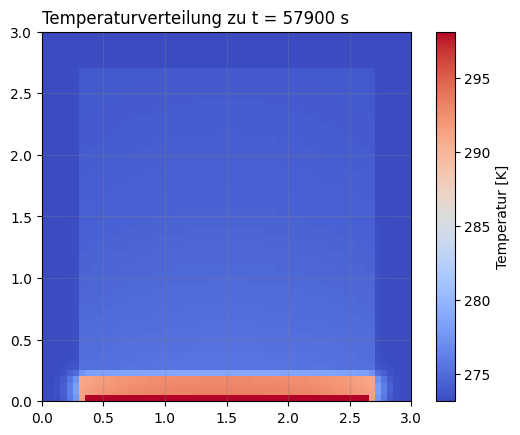

In [179]:
for k in range(len(tiles[0].temps)):
    ## k = 0  # Zeitpunkt
    #if k % int(t//frames)  != 0:
    #    continue
    temp_map = get_temp_matrix(tile_matrix, k)

    plt.imshow(temp_map, cmap='coolwarm', origin='lower', extent=[0, delta_x * n, 0, delta_y * n],
           vmin=273.15, vmax=298.15)
    plt.title(f"Temperaturverteilung zu t = {round(k*delta_t, 3)} s", loc='left')
    plt.colorbar(label='Temperatur [K]')
    plt.grid(True, color='gray', alpha=0.3)

    plt.savefig(f"frames_dt_analysis/temperatur_t{(k*delta_t):.2f}s.png", dpi=300, bbox_inches='tight')
    plt.close()

In [ ]:
frame_dir = "frames_dt_analysis"
filenames = natsorted([
    os.path.join(frame_dir, f) for f in os.listdir(frame_dir)
    if f.endswith(".png")
])

# Ausgabe-Datei
output_path = "schweineheizung_dt_analysis.mp4"

# Video erstellen
with imageio.get_writer(output_path, fps=10) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"Video gespeichert als {output_path}")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1561, 1302) to (1568, 1312) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Video gespeichert als schweineheizung_dt_analysis.mp4


In [181]:
delta_t = 20
steps = int(t//delta_t)

for i in range(steps):
    if i == 0:
        for tile in tiles:
            tile.temps = tile.temps[:1]  # alles außer Startwert löschen

    F = create_vector_F(tiles, tile_matrix, T_u)
    T_n = np.linalg.solve(B, F)
    for temp,  tile in zip(T_n, tiles):
        tile.temps.append(temp)

In [183]:
k = int(86400/delta_t)

temp_map = get_temp_matrix(tile_matrix, k)

plt.imshow(temp_map, cmap='coolwarm', origin='lower', extent=[0, delta_x * n, 0, delta_y * n],
       vmin=273.15, vmax=298.15)
plt.title(f"Temperaturverteilung zu t = {round(k*delta_t, 3)} s", loc='left')
plt.colorbar(label='Temperatur [K]')
plt.grid(True, color='gray', alpha=0.3)

plt.savefig(f"frames_dt=20/temperatur_t{(k*delta_t):.2f}s.png", dpi=300, bbox_inches='tight')
plt.close()

In [187]:
#TODO: ES fehlen noch die anderen verfahren. 

### Vergleich aller drei Verfahren für verschiedene Zeitschritte.

In der Animation lässt sich nicht erkennen, dass das System instabil ist, aber die Endergebnisse weichen deutlich voneinander ab. 

Oben Links: 60s Zeitschritt         - Rechenzeit:  18 min 2 sek 100 ms

Oben Rechts: 300s Zeitschritt       - Rechenzeit:  3 min 40 sek 100 ms

Unten Links: Stationärer Fall       - Rechenzeit:               800 ms

Unten Rechts: 20s Zeitschritt       - Rechenzeit: 55 min 16 sek 700 ms

<img src="img/1.png" width="400">
<img src="img/2.png" width="400">
<img src="img/3.png" width="400">
<img src="img/4.png" width="400">

### Diskussion der Abweichungen, Rechenzeiten, Stabilität.

Für die instationäre Berechnung wurden drei verschiedene Zeitschritte ( $\Delta t=20 \mathrm{~s}, 60 \mathrm{~s}$ und 300 s) sowie der stationäre Fall betrachtet. Die in der Stabilitätsanalyse ermittelte maximale Schrittweite für das explizite Eulerverfahren beträgt $t_{\text {max }} \approx 10,73 \mathrm{~s}$. Alle verwendeten Zeitschritte liegen damit über der Stabilitätsgrenze, was insbesondere für das explizite Eulerverfahren bedeutet, dass die formale Stabilitätsbedingung verletzt wird. In der Animation ist zwar keine sofortige Instabilität zu erkennen, die Endergebnisse unterscheiden sich jedoch deutlich voneinander, was auf Zeitdiskretisierungsfehler und bei expliziten Verfahren auf schleichende Instabilität zurückzuführen ist.

Die Rechenzeiten variieren stark: Mit $\Delta t=300 \mathrm{~s}$ wurde eine sehr kurze Laufzeit von etwa 3 min 40 s erreicht, allerdings weicht die Lösung hier am stärksten von der stationären Referenz ab. Mit $\Delta t=60 \mathrm{~s}$ beträgt die Rechenzeit rund 18 min , die Lösung ist etwas genauer, zeigt aber immer noch deutliche Abweichungen. Mit $\Delta t=20 \mathrm{~s}$ steigt die Rechenzeit auf rund 55 min, die Lösung nähert sich stärker der stationären Temperaturverteilung an, liegt aber aufgrund der Überschreitung der Stabilitätsgrenze noch nicht im optimalen Bereich. Auf eine Berechnung mit einem Zeitschritt unter 10 s , der die Stabilitätsbedingung des expliziten Verfahrens erfüllen würde, wurde verzichtet, da die geschätzte Rechenzeit hierfür derzeit über drei Stunden betragen würde.

Als Referenz wurde die stationäre Temperaturverteilung berechnet, welche in nur 800 ms vorlag. Diese sehr kurze Berechnungszeit war nur durch die Verwendung einer scipy.sparse -Matrixdarstellung in Kombination mit einem darauf optimierten linearen Gleichungslöser möglich. Der Vergleich mit den instationären Ergebnissen zeigt deutlich, dass größere Zeitschritte zu einer Glättung und Abweichung vom physikalisch erwarteten Temperaturfeld führen. Crank-Nicolson und implizites Euler wären hier zwar formal stabil, leiden bei großen Zeitschritten jedoch unter Dämpfungs- bzw. Phasenfehlern.

Insgesamt lässt sich festhalten, dass für hohe Genauigkeit ein Zeitschritt im Bereich von $\Delta t \approx 10 \mathrm{~s}$ nötig wäre, was jedoch aktuell aus praktischen Gründen nicht realisierbar ist. Ein sinnvoller Kompromiss zwischen Rechenzeit und Genauigkeit kann durch die Wahl des Crank-Nicolson-Verfahrens mit moderaten Zeitschritten, etwa 60 s , erreicht werden.

## 3. Instationäre Problemstellung

Darstellung und Diskussion der zeitlichen Temperaturentwicklung

Vergleich mit stationärem Endzustand

In [188]:
# TODO: Die Lösung der Aufgabe fehlt noch.